# PySpark - GeoPandas Example

*Rob Knapen, Wageningen Environmental Research*
<br>

A notebook to investigate using GeoPandas for spatial data operations and PySpark to (potentially) run them on a compute cluster. This could be useful for processing large datasets of species observations.

Note that installation is slightly tricky due to the mixing of Python with the JVM (Scala/Java) based Spark and the use of latest developments for bridging them (in pyspark, such as Apache Arrow). Transporting spatial data between both environments adds some additional complexity. This notebook is tested with Spark 3.4.0 (currently the latest version).

### Import Packages
Some imports are for future use :-)

Hint: Make sure pyspark package version matches the installed Apache Spark version!

In [2]:
import os
os.environ['USE_PYGEOS'] = '0'

import geopandas.geoseries
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10, 5)

# for exponential back down when calling APIs
from retrying import retry

# PySpark libraries
import pyspark.sql.functions as func
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DecimalType
from pyspark.sql import SparkSession

# Spatial pandas libraries
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon, shape
from shapely import wkb, wkt

# Used to decode data from Java
from ast import literal_eval as make_tuple

### Create a Spark Session

In [3]:
spark = SparkSession.builder.appName("fairicube-geopandas").getOrCreate()
sc = spark.sparkContext
sc

23/05/03 20:01:06 WARN Utils: Your hostname, robs-m1pro.local resolves to a loopback address: 127.0.0.1; using 192.168.68.106 instead (on interface en0)
23/05/03 20:01:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/03 20:01:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=fairicube-geopandas>

### Load sample species observation data
As an example a dataset from the Dutch 'Nationale Databank Flora en Fauna' (ndff.nl). While we are hoping for this to be available as open data (soon), it is not yet. However, we have permission to use it for the FAIRiCUBE EU project.

In [4]:
# the NDFF datafile to process
species_filename = "../../../local/data/ndff/broedvogels_2016.csv"

# the columns to drop right away
always_drop_cols_from_source = None

In [6]:
species_df = pd.read_csv(species_filename, header='infer', sep=';', on_bad_lines='warn')

# remove not needed columns
if always_drop_cols_from_source:
    species_df.drop(columns=always_drop_cols_from_source, inplace=True)

# remove the crs prefix from the wkt data
species_df['wkt_excl_crs'] = species_df['wkt'].map(lambda x: x.split(';')[1], na_action='ignore')
species_df.drop(columns=['wkt'], inplace=True)
species_df.rename(columns={'wkt_excl_crs': 'wkt'}, inplace=True)

species_df.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,wkt
0,Krakeend,Anas strepera,2016,territorium,1,71,"POLYGON((247282 584478,247280.535533906 584474..."
1,Zwartkop,Sylvia atricapilla,2016,territorium,1,283,"POLYGON((65405.294923655 436165.134083641,6540..."
2,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON((188642.918478918 344195.927912087,188..."
3,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON((169116.484375 446596.0625,169113.5554..."
4,Spreeuw,Sturnus vulgaris,2016,nest,1,283,"POLYGON((127692 427328,127689.071067812 427320..."


In [7]:
# get stats on the numerical data
species_df.describe()

,jaar,straal
count,454452.0,454452.000000
mean,2016.0,221.808154
std,0.0,106.919241
min,2016.0,3.000000
25%,2016.0,71.000000
50%,2016.0,283.000000
75%,2016.0,283.000000
max,2016.0,488.000000


In [8]:
# get stats on the species
species_df['sci_name'].value_counts(sort=True, dropna=True)

sci_name
Sylvia atricapilla         22475
Troglodytes troglodytes    18088
Phylloscopus collybita     16349
Sylvia communis            14712
Phylloscopus trochilus     14189
                           ...  
Pernis apivorus               78
Spinus spinus                 77
Serinus serinus               53
Ardea purpurea                42
Corvus corax                  34
Name: count, Length: 129, dtype: int64

### Create a GeoPandas DataFrame
The observations have spatial attributes, so lift them into a GeoPandas DataFrame to be able to process them.

In [9]:
# construct a GeoDataFrame, with the data using the Dutch RD coordinate reference system
gs = gpd.GeoSeries.from_wkt(species_df['wkt'])
species_gdf = gpd.GeoDataFrame(species_df, geometry=gs, crs="EPSG:28992")

# transform the dataset to the more common WGS84 (unprojected) CRS
species_gdf.to_crs(crs="EPSG:4326", inplace=True)
species_gdf.drop(columns=['wkt'], inplace=True)

species_gdf.head(5)

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
0,Krakeend,Anas strepera,2016,territorium,1,71,"POLYGON ((6.76944 53.23891, 6.76942 53.23888, ..."
1,Zwartkop,Sylvia atricapilla,2016,territorium,1,283,"POLYGON ((4.08519 51.90677, 4.08514 51.90670, ..."
2,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON ((5.86735 51.08631, 5.86731 51.08625, ..."
3,Zanglijster,Turdus philomelos,2016,territorium,1,283,"POLYGON ((5.59280 52.00755, 5.59276 52.00749, ..."
4,Spreeuw,Sturnus vulgaris,2016,nest,1,283,"POLYGON ((4.99101 51.83388, 4.99097 51.83382, ..."


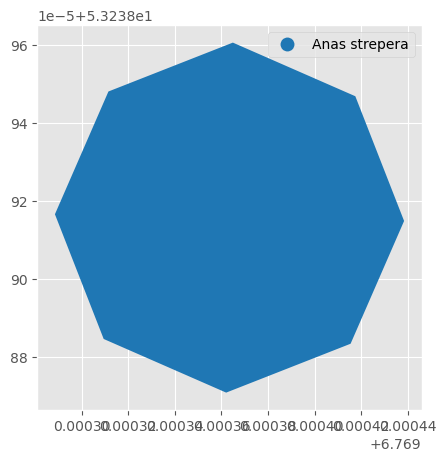

In [10]:
# display a single sample observation
sample_gdf = species_gdf[0:1]
sample_gdf.plot(column='sci_name', categorical=True, legend=True)
plt.show()

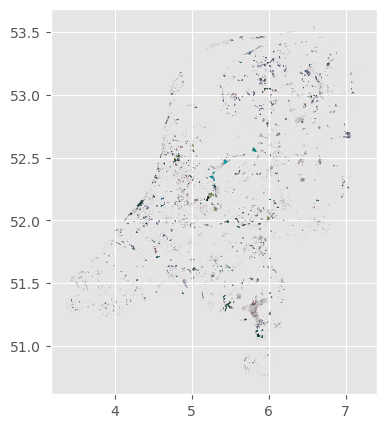

In [11]:
# display all species observations (this might take a while to draw)
species_gdf.plot(column='sci_name', categorical=False, legend=False)
plt.show()

### Create a Spark DataFrame
Here comes the more tricky part to lift the GeoDataFrame into a Spark (distributed) DataFrame.

In [12]:
# take a small sample to experiment with
small_gdf = species_gdf[0:100000].copy()

# have to convert the geometry objects (back) to wkt strings for Spark compatibility
small_gdf['wkt'] = pd.Series(
    small_gdf['geometry'].map(lambda x: str(x.wkt), na_action='ignore'),
    index=small_gdf.index, dtype='string'
)

# get rid of the geometry objects that Spark can not automatically interpret
small_gdf.drop(columns=['geometry'], axis=1, inplace=True)

small_gdf

,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,wkt
0,Krakeend,Anas strepera,2016,territorium,1,71,"POLYGON ((6.769438326417666 53.23891492255171,..."
1,Zwartkop,Sylvia atricapilla,2016,territorium,1,283,"POLYGON ((4.085185233820107 51.90676591847973,..."
2,Zanglijster,Turdus philomelos,2016,territorium,1,283,POLYGON ((5.867354202207429 51.086309317126705...
3,Zanglijster,Turdus philomelos,2016,territorium,1,283,POLYGON ((5.5928016848454805 52.00755325266374...
4,Spreeuw,Sturnus vulgaris,2016,nest,1,283,"POLYGON ((4.9910098172015385 51.8338788815398,..."
...,...,...,...,...,...,...,...
99995,Tjiftjaf,Phylloscopus collybita,2016,territorium,1,283,"POLYGON ((4.832073742638954 52.29438888879903,..."
99996,Gele kwikstaart,Motacilla flava,2016,territorium,1,283,POLYGON ((5.947837833845022 52.688918053836204...
99997,Grasmus,Sylvia communis,2016,levend exemplaar,1,71,"POLYGON ((4.563577858591261 52.44180456260117,..."
99998,Blauwborst,Luscinia svecica,2016,territorium,1,283,"POLYGON ((4.146252707606594 51.55353991093142,..."


In [13]:
# now create a Spark DataFrame from the GeoPandas DataFrame
spark_df = spark.createDataFrame(data=small_gdf)
spark_df.printSchema()

root
 |-- nl_name: string (nullable = true)
 |-- sci_name: string (nullable = true)
 |-- jaar: long (nullable = true)
 |-- countsubject: string (nullable = true)
 |-- orig_abundance: string (nullable = true)
 |-- straal: long (nullable = true)
 |-- wkt: string (nullable = true)



In [14]:
spark_df.show(10, truncate=True)

23/05/03 20:04:39 WARN TaskSetManager: Stage 0 contains a task of very large size (3352 KiB). The maximum recommended task size is 1000 KiB.
23/05/03 20:04:44 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


+-----------------+--------------------+----+----------------+--------------+------+--------------------+
|          nl_name|            sci_name|jaar|    countsubject|orig_abundance|straal|                 wkt|
+-----------------+--------------------+----+----------------+--------------+------+--------------------+
|         Krakeend|       Anas strepera|2016|     territorium|             1|    71|POLYGON ((6.76943...|
|         Zwartkop|  Sylvia atricapilla|2016|     territorium|             1|   283|POLYGON ((4.08518...|
|      Zanglijster|   Turdus philomelos|2016|     territorium|             1|   283|POLYGON ((5.86735...|
|      Zanglijster|   Turdus philomelos|2016|     territorium|             1|   283|POLYGON ((5.59280...|
|          Spreeuw|    Sturnus vulgaris|2016|            nest|             1|   283|POLYGON ((4.99100...|
|Zwarte roodstaart|Phoenicurus ochruros|2016|levend exemplaar|             1|   283|POLYGON ((5.11384...|
|         Koolmees|         Parus major|2016| 

In [15]:
# now we can put Spark to work ...
spark_df.select("sci_name", "orig_abundance", 'straal').summary().show()

23/05/03 20:05:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/05/03 20:05:04 WARN TaskSetManager: Stage 1 contains a task of very large size (3352 KiB). The maximum recommended task size is 1000 KiB.


+-------+-----------------+------------------+------------------+
|summary|         sci_name|    orig_abundance|            straal|
+-------+-----------------+------------------+------------------+
|  count|           100000|            100000|            100000|
|   mean|             null|1.3556855685568556|         221.65515|
| stddev|             null|30.871941773628674|107.16397570851129|
|    min|  Accipiter nisus|                 *|                 3|
|    25%|             null|               1.0|                71|
|    50%|             null|               1.0|               283|
|    75%|             null|               1.0|               283|
|    max|Vanellus vanellus|                96|               488|
+-------+-----------------+------------------+------------------+

